In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSMobility, ACSTravelTime
from FairnessEvaluator import FairnessEvaluator

import matplotlib.pyplot as plt 

In [5]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["NY"], download=True)

DEBUG: Working on ACSEmployment
DEBUG: Working on ACSIncome
DEBUG: Working on ACSPublicCoverage
DEBUG: Working on ACSMobility
DEBUG: Working on ACSTravelTime


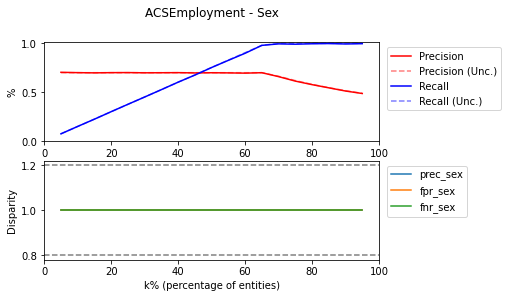

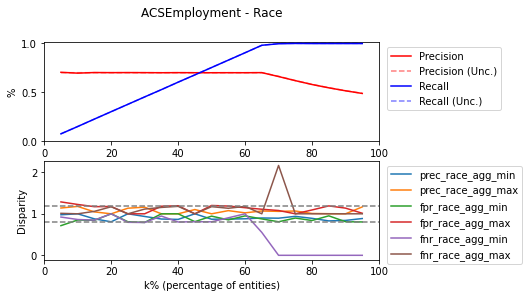

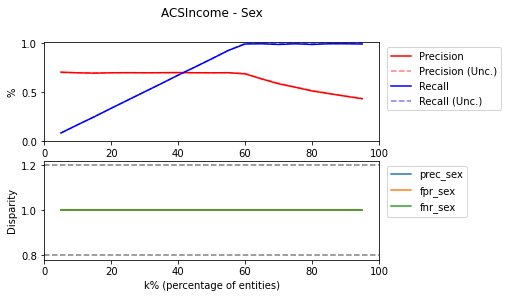

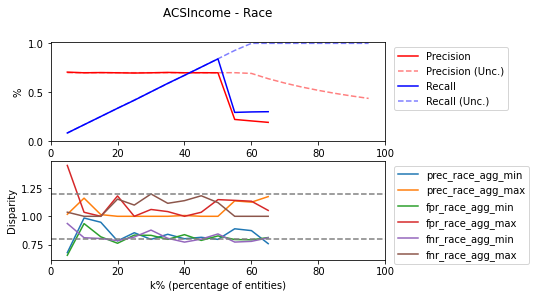

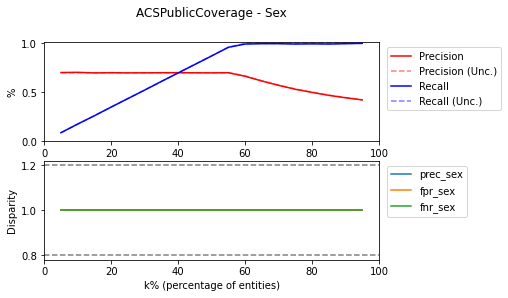

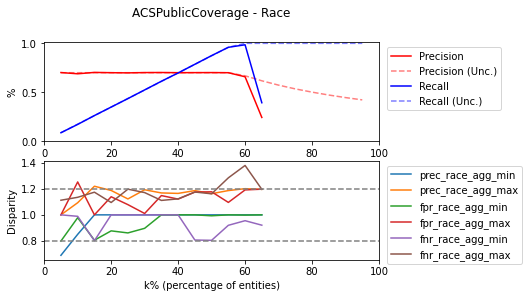

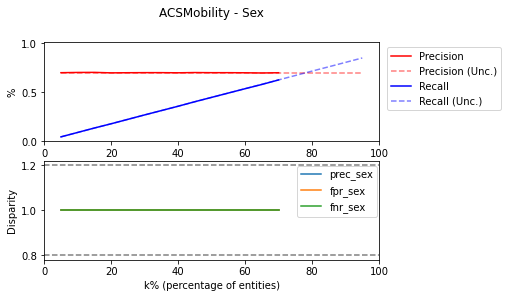

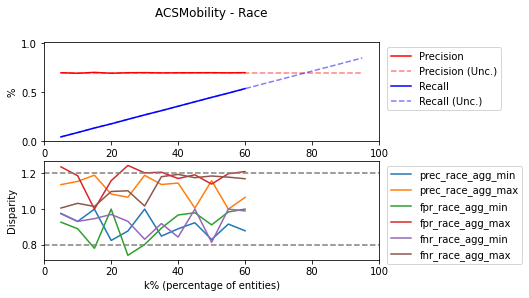

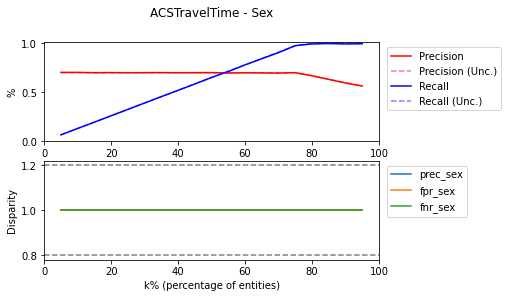

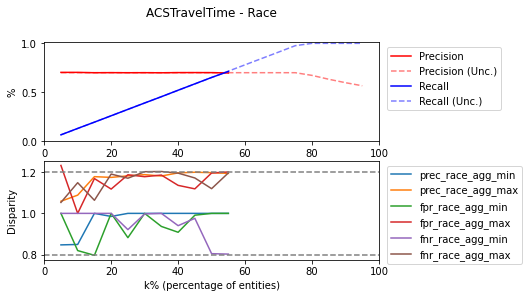

In [6]:
dataset_names = ['ACSEmployment', 'ACSIncome', 'ACSPublicCoverage', 'ACSMobility', 'ACSTravelTime']

results_columns = ['dataset','sample_size','overall_prev','sensitive_attr','group_dist','group_prev','max_group_prev_diff']
results_df = pd.DataFrame(
            columns=(results_columns)
)

fo_results = {}

def maxDiff(a):
    a.sort()
    vmin = a[0]
    dmax = 0
    for i in range(len(a)):
        if (a[i] < vmin):
            vmin = a[i]
        elif (a[i] - vmin > dmax):
            dmax = a[i] - vmin
    return dmax

RAC1P_mapper = {1:1,
                2:2,
                3:4,
                4:4,
                5:4,
                6:3,
                7:4,
                8:4,
                9:4}

SEX_mapper = {1: 1,
              2: 2}

HISP_mapper = {x: 1 if x == 0 else 2 for x in range(0, 24)}

# New codes:
# 1 - White alone
# 2 - Black or African American alone
# 3 - Asian alone
# 4 - Other

race_agg_names = {1: 'White',
                  2: 'Black or African American alone',
                  3: 'Asian alone',
                  4: 'Other'}

# New codes:
# 1 - Male
# 2 - Female

sex_names = {1: 'Male',
             2: 'Female'}

# New codes:
# 1 - Not Hispanic or Latinx
# 2 - Hispanic or Latinx

hisp_names = {1: 'Not Hispanic or Latinx',
              2: 'Hispanic or Latinx'}

sample_dfs = {}

for dataset_name in dataset_names:
    print(f"DEBUG: Working on {dataset_name}")

    # Dict for new record
    r = {}
    r['dataset'] = dataset_name

    features, label, group = eval(dataset_name + '.df_to_numpy(acs_data)')
    feature_names = eval(dataset_name + '.features')
    #feature_names.append('HISP')
    df = pd.DataFrame(features, columns = feature_names)
    df['label'] = 1*label

    # Recode sex and race
    df['race_agg'] = df['RAC1P'].map(RAC1P_mapper)
    df['sex'] = df['SEX'].map(SEX_mapper)
    #df['hisp'] = df['HISP'].map(HISP_mapper)

    increase_test_size = True
    test_size = 0.01
    while increase_test_size:
        if df.shape[0]*test_size < 1000:
            test_size+=0.01
        else:
            increase_test_size = False
    
    _, sample_df = train_test_split(df, test_size=test_size, stratify=df[['race_agg','sex','label']],random_state=42)
    sample_df = sample_df.reset_index()

    sample_dfs[dataset_name] = sample_df

    r['sample_size'] = sample_df.shape[0]
    r['overall_prev'] = round(sample_df['label'].value_counts(normalize=True)[1]*100, 2)

    sample_df['race_agg_names'] = sample_df['race_agg'].map(race_agg_names)
    sample_df['sex_names'] = sample_df['sex'].map(sex_names)    

    # Get sex dist
    sex_dist_dict = {}
    sex_dist = sample_df['sex_names'].value_counts(normalize=True)
    for x in list(sample_df['sex_names'].unique()):
        sex_dist_dict[x] = round(sex_dist[x]*100,2)

    # Get sex group prev
    sex_prev_dict = {}
    sex_prev = pd.crosstab(sample_df['sex_names'], sample_df['label'], normalize='index')
    for x in list(sample_df['sex_names'].unique()):
        sex_prev_dict[x] = round(sex_prev[1][x]*100,2)

    sex_max_prev_diff = round(maxDiff(list(sex_prev_dict.values())),2)

    r['sensitive_attr'] = 'sex'
    r['group_dist'] = sex_dist_dict
    r['group_prev'] = sex_prev_dict
    r['max_group_prev_diff'] = sex_max_prev_diff

    results_df = results_df.append(r, ignore_index=True)

    #print("Sex: ")
    fo = FairnessEvaluator(sample_df,
                            'label',
                            ['sex'],
                            #metrics=['tpr','fpr','fnr'],
                            metrics_to_plot=['prec','fpr','fnr'],
                            fairness_bounds=[0.8,1.2],
                            fully_constrained=False,
                            #intersectionality=None,
                            precision_ub = 0.7#,
                            #disparity_ratio=True,
                            #epsilon=0.05
                            )
    
    fo.evaluate()
    fo.plot()
    plt.title(f'{dataset_name} - Sex', y=2.4)

    key_temp = f'{dataset_name}_sex'
    fo_results[key_temp] = fo.results_df

    # Get race dist
    race_dist_dict = {}
    race_dist = sample_df['race_agg_names'].value_counts(normalize=True)
    for x in list(sample_df['race_agg_names'].unique()):
        race_dist_dict[x] = round(race_dist[x]*100,2)

    # Get race group prev
    race_prev_dict = {}
    race_prev = pd.crosstab(sample_df['race_agg_names'], sample_df['label'], normalize='index')
    for x in list(sample_df['race_agg_names'].unique()):
        race_prev_dict[x] = round(race_prev[1][x]*100,2)

    race_max_prev_diff = round(maxDiff(list(race_prev_dict.values())),2)

    r['sensitive_attr'] = 'race'
    r['group_dist'] = race_dist_dict
    r['group_prev'] = race_prev_dict
    r['max_group_prev_diff'] = race_max_prev_diff

    results_df = results_df.append(r, ignore_index=True)

    #print("Race: ")
    fo = FairnessEvaluator(sample_df,
                        'label',
                        ['race_agg'],
                        metrics=['tpr','fpr','fnr'],
                        metrics_to_plot=['prec','fpr','fnr'],
                        fairness_bounds=[0.8,1.2],
                        fully_constrained=False,
                        #intersectionality=None,
                        precision_ub = 0.7#,
                        #disparity_ratio=True,
                        #epsilon=0.05
                        )
    fo.evaluate()
    fo.plot()
    plt.title(f'{dataset_name} - Race', y=2.4)

    key_temp = f'{dataset_name}_race'
    fo_results[key_temp] = fo.results_df

In [ ]:
results_df

,dataset,sample_size,overall_prev,sensitive_attr,group_dist,group_prev,max_group_prev_diff
0,ACSEmployment,1970,46.45,sex,"{'Male': 48.32, 'Female': 51.68}","{'Male': 48.74, 'Female': 44.3}",4.44
1,ACSEmployment,1970,46.45,race,"{'White': 70.3, 'Asian alone': 8.63, 'Other': ...","{'White': 47.36, 'Asian alone': 50.0, 'Other':...",8.29
2,ACSIncome,1031,41.51,sex,"{'Female': 49.37, 'Male': 50.63}","{'Female': 35.76, 'Male': 47.13}",11.37
3,ACSIncome,1031,41.51,race,"{'Other': 8.05, 'White': 71.48, 'Black or Afri...","{'Other': 25.3, 'White': 44.91, 'Black or Afri...",19.61
4,ACSPublicCoverage,1352,40.09,sex,"{'Male': 43.86, 'Female': 56.14}","{'Male': 41.65, 'Female': 38.87}",2.78
5,ACSPublicCoverage,1352,40.09,race,"{'White': 62.57, 'Black or African American al...","{'White': 35.22, 'Black or African American al...",17.21
6,ACSMobility,1214,78.17,sex,"{'Female': 50.41, 'Male': 49.59}","{'Female': 77.29, 'Male': 79.07}",1.78
7,ACSMobility,1214,78.17,race,"{'Black or African American alone': 13.67, 'Ot...","{'Black or African American alone': 81.33, 'Ot...",6.11
8,ACSTravelTime,1824,53.78,sex,"{'Female': 49.4, 'Male': 50.6}","{'Female': 51.72, 'Male': 55.8}",4.08
9,ACSTravelTime,1824,53.78,race,"{'Asian alone': 9.27, 'White': 71.66, 'Other':...","{'Asian alone': 66.86, 'White': 48.51, 'Other'...",20.64


In [ ]:
#results_df['prev_ratio'] = results_df.apply(lambda row: (row['max_group_prev_diff'] / row['overall_prev']), axis=1)
#results_df

In [7]:
#results_df.to_csv('results/folktables-results.csv',index=False)